# Tutorial: Ideal chain, Monte Carlo, and central limit

Jelle Aalbers, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In this tutorial, we explore the entropic force exerted by an [ideal chain](https://en.wikipedia.org/wiki/Ideal_chain): a highly simplified model of a long polymer molecule such as those found in a [rubber band](https://en.wikipedia.org/wiki/Rubber_band_experiment#Ideal_chain_polymer).

An ideal chain polymer consists of multiple "mers", each a fixed distance apart, but at a random angle. Since there are many possible configurations where the chain is bunched up, but few where the polymer is fully stretched, there will be an entropic force that resists stretching.

The tutorial is also an opportunity to practice your data analysis (Python + statistics) skills, as we we discuss unit testing, vectorization, and density estimation.

As always, if you see functions or concepts you don't understand, use your resources:
  * The `?` magic and shift+tab pop-up help in jupyter;
  * Search the internet (especially [docs.python.org](https://docs.python.org/3/) and the [numpy](https://numpy.org/doc/stable/) and [scipy docs](https://docs.scipy.org/doc/scipy/));
  * Ask your classmates and TAs;
  * Come see me during office hours!

The tutorial has four parts, each with one or more exercises. Answers will be provided.
  1. Simulating one polymer chain
  2. Simulating multiple polymer chains
  3. Force calculation from a histogram
  4. Force calculation from the Central Limit Theorem

## Part 1: simulating one polymer

**Exercise 1a: Complete the code for simulating a polymer below.**

In [2]:
def simulate_polymer(n_mers=100):
    """Return a random (n_mers, 3) array of mer positions
    for an ideal chain with links of length 1 and random orientations
    
    Arguments:
     - n_mers: polymer chain length
    """
    # Distribution of points on a 3d unit sphere (scipy >= v1.10)
    unit_sphere = scipy.stats.uniform_direction(dim=3)

    # Generate a (n_mers, 3) array of random 3D unit vector positions
    # 'rvs' means: random variates
    ########
    # YOUR CODE HERE
    ########

    # Take the cumulative sum to find the linked mer positions
    polymer = np.cumsum(link_vectors, axis=0)
    
    return polymer

Hint: Use numpy's [cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) function.

Before proceeding further, we should write [unit tests](https://realpython.com/python-testing/#unit-tests-vs-integration-tests) that verify your function works as intended.

**Exercise 1B: complete the unit test that checks if the polymer links have length 1.**

Hint: look for a nice numpy function that might help you. (Or try to phrase a Google query so you will be led to one.)

In [3]:
# Test we get the correct polymer length
polymer = simulate_polymer(100)
assert polymer.shape == (100, 3), "Polymer shape incorrect"

# Test that the links all have length one

# First, recover the link unit vectors
link_vectors = np.diff(polymer, axis=0)

# Next, calculate the lengths of each link
########
# YOUR CODE HERE
########
# link_lengths = ...

# Check the link lengths are all close to 1
np.testing.assert_allclose(link_lengths, 1)

If you're wondering why we only check the lengths are 'approximately' equal to one, see e.g. [here](https://stackoverflow.com/questions/5595425) and links therein.

Now it's time to plot your polymer in 3D! Matplotlib's 3D plotting API can be a little overwhelming, so I'll give you this one for free. Try to understand how the code works -- maybe you can make a prettier plot?

In [4]:
def plot_polymer(polymer):
    """Plot a 3d polymer configuration
    
    Arguments:
     - polymer: (n_mers, 3) array of mer positions
    """
    # Create a 3D plotting axis
    ax = plt.figure().add_subplot(projection='3d')

    # Plot the mers. Note plot expects x, y, z as positional arguments.
    # but we have a (n, 3) array.
    #   - .T transposes to a (3, n) array
    #   - the star does 'argument unpacking' -- Google if you haven't seen this before
    ax.plot(*(polymer.T), marker='.', markersize=3)
    
    # Plot the endpoints with a bigger marker
    # Passing a list like [0, -1] as a numpy array index lets you pick
    # non-sequential indices.
    ax.scatter(*polymer[[0, -1]].T, s=20, c='r')

    # Use equal limits in all three dimensions
    r = max(-np.min(polymer), np.max(polymer))
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)


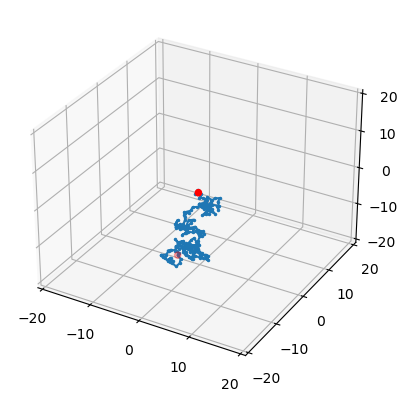

In [5]:
polymer = simulate_polymer(n_mers=200)
plot_polymer(polymer)

## Part 2: Simulating multiple polymers

We need to simulate a lot of different polymer configurations to find out how likely different polymer lengths are. We could simply call our single-polymer simulation function in a for loop or [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

**Exercise 2a. Complete the code for simulating multiple polymers below**

In [6]:
def simulate_polymers(size=10_000, n_mers=100):
    """Return (size, n_mers, 3) array with n_trials 3d mer positions
    of polymers of length n_mers
    
    Arguments:
     - size: number of polymers to simulate
     - n_mers: number of mers in one polymer
    """
    # Create a list of polymers
    ########
    # YOUR CODE HERE
    ########
    
    # Convert to a single numpy array. np.asarray would also work.
    return np.stack(polymer_list)

And being good coders, we should add some unit tests:

In [7]:
polymers = simulate_polymers(size=4, n_mers=10)
assert polymers.shape == (4, 10, 3), "Incorrect shape"

**Exercise 2b. Try `polymer_list = [simulate_polymer(n_mers)] * size` instead of the correct solution in the function above. Something will go badly wrong! Find out what the problem is, and write a unit test that fails on this incorrect implementation (and not on a correct implementation).**

In [8]:
########
# YOUR CODE HERE
########

In general, please be careful when using list multiplication in Python, see e.g. [this stackoverflow question](https://stackoverflow.com/questions/240178). And of course, use numpy arrays when you can.

If we want our code to be fast, modern, and beautiful, we should avoid call small functions (like `simulate_polymer`) in pure-Python for loops. Python's objects and functions have large overheads compared to lower-level languages like C++ -- but even in those language, for-loops may not perform so well on modern hardware (especially on GPUs).

Instead, we can use **vectorization**, see e.g. [here](https://www.askpython.com/python-modules/numpy/vectorization-numpy) and [here](https://en.wikipedia.org/wiki/Array_programming). This means we slightly change `simulate_polymer` to work with an array of polymers all the way through. Numpy and scipy functions almost always let you do this.

(An alternative would be to use [just-in-time compiling with numba](https://numba.pydata.org/); but vectorization is a technique that will  also pay off when you move to machine learning frameworks like [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/)).

**Exercise 2c. Complete the code for simulate_polymers_fast below.**

In [9]:
def simulate_polymers_fast(size=10_000, n_mers=100):
    """Return (size, n_mers, 3) array with n_trials 3d mer positions
    of polymers of length n_mers
    
    Arguments:
     - size: number of polymers to simulate
     - n_mers: number of mers in one polymer
    """
    # Distribution of points on a 3d unit sphere (scipy >= v1.10)
    unit_sphere = scipy.stats.uniform_direction(dim=3)
    
    # Generate a (size, n_mers, 3) array of random 3D unit vector positions
    # 'rvs' means: random variates
    link_vectors = unit_sphere.rvs(size=(size, n_mers))
    
    # Take the cumulative sum to find the linked mer positions
    ########
    # YOUR CODE HERE
    ########
    
    return polymers

Run your unit tests again to show that this function works correctly, just like the naive for-loop implementation

With the [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit), we can check that this approach is indeed significantly faster:

In [10]:
%%timeit
simulate_polymers()

359 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
simulate_polymers_fast()

90 ms ± 4.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


If we were writing a library, we shouldn't keep our old `simulate_polymer` around as well, since it's code is almost the same as `simulate_polymers`. Instead, we could write a short adapter function:
However, we did write some nice unit tests for `simulate_polymer`. To avoid changing all those, we can write a short adapter function:

```python
def simulate_polymer(n_mers):
    """Return a random (n_mers, 3) array of mer positions
    for an ideal chain with links of length 1 and random orientations
    
    Arguments:
     - n_mers: polymer chain length
    """
    return simulate_polymers(1, n_mers)[0]
```

and use our unit tests to show `simulate_polymer` still works.

## Part 3: Density estimation

To find the entropic force exerted by the ideal chain, we need to know the density of allowed states $W(x)$ as a function of the endpoint position $x$ in one of the dimensions -- let's say the first. A more careful treatment would stipulate precisely what happens to the other two dimensions; for now, we simply ignore them.

We're going to use [density estimation](https://en.wikipedia.org/wiki/Density_estimation) to find the density of states from a large ("high statistics") simulation. The simplest density estimation technique is a [histogram](https://en.wikipedia.org/wiki/Histogram); if you feel adventures you might try a Kernel Density Estimate (KDE) instead (see e.g. [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html), [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html) and [here](https://en.wikipedia.org/wiki/Kernel_density_estimation)).

We're going to use matplotlib's [plt.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) here; this uses [numpy.histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html#numpy.histogram) under the hood. If you use histograms regularly it's well worth learning about the [hist](https://pypi.org/project/hist/) package, written by some clever LHC physicists.

**Exercise 3a: Complete the code below.**

Text(0, 0.5, 'Density of states $W(x)$')

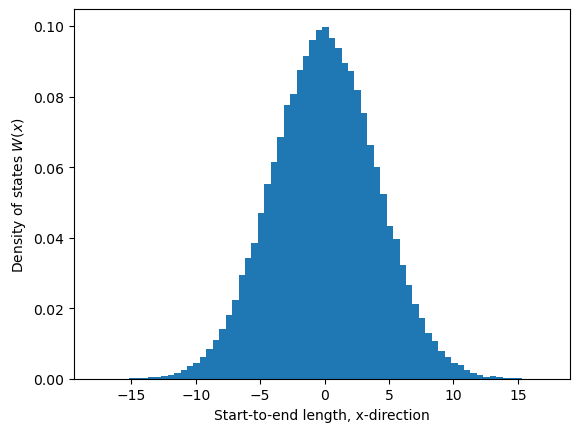

In [12]:
# Simulate a lot of polymers
n_mers = 50
polymers = simulate_polymers_fast(size=int(1e5), n_mers=n_mers)

# Calculate end-to-end distances in the x-dimension 
########
# YOUR CODE HERE
########
# end_to_end = ...

# Histogram the distances
n_bins = 70
density, bin_edges, _ = plt.hist(end_to_end, bins=n_bins, density=True, label='Histogram')

plt.xlabel("Start-to-end length, x-direction")
plt.ylabel("Density of states $W(x)$")

What happens if you don't pass the density=True argument?

As we discussed in lecture, the entropic force exerted by the chain is 

\begin{equation}
F = T \frac{dS}{dx}\Bigr|_T
\end{equation}

And since

\begin{equation}
S = k_B \ln W
\end{equation}

we have

\begin{equation}
\frac{F}{kB T} = \frac{\partial \ln W}{dx}
\end{equation}

Since we only have an approximate numerical result for $W$, we'll have to use [finite differences](https://en.wikipedia.org/wiki/Numerical_differentiation#Finite_differences) to compute the derivative.

**Exercise 3b: Complete the code below.**

Hints:
  * You might use a calculation involving `np.diff`, but this will reduce the number of elements in the array (so you can't plot it against `bin_centers` directly).
  * ... but maybe numpy has an even more convenient function you could? Perhaps one that does even better than a first-order finite difference calculation?
  

/tmp/ipykernel_31344/4157003896.py:5: RuntimeWarning: divide by zero encountered in log
  dlogw_dx = np.gradient(np.log(density), bin_width)


Text(0, 0.5, '$\\partial \\ln W / \\partial x = F /( k_B T )$')

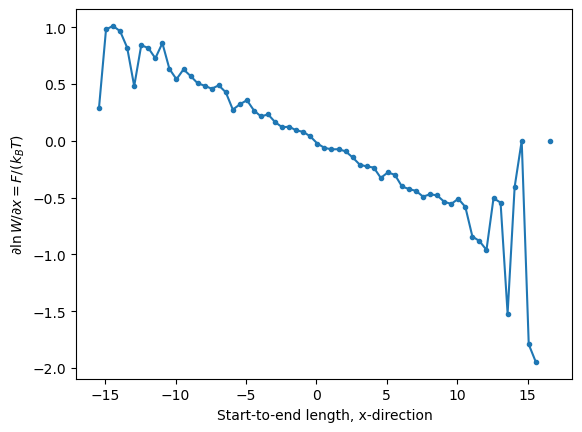

In [13]:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# Calculate the derivative of the state density, d[ ln W(x) ]/dx
########
# YOUR CODE HERE
########
# dlogw_dx = ...

# Calculate the derivative of 
plt.plot(bin_centers, dlogw_dx, marker='.')

plt.xlabel("Start-to-end length, x-direction")
plt.ylabel("$\partial \ln W / \partial x = F /( k_B T )$")

This looks consistent with a Hooke's law force... for the most part. Here are some further questions you might want to explore:
  * What do you think is going on at the far edges of the graph?
  * Does the result depend on the number of bins in the histogram? What do you think is a good setting?
  * What happens to the entropic force if you decrease the number of mers, say to 5 or 2?

## Part 4: Force calculation from the central limit theorem

A powerful theorem of statistics called the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem#Classical_CLT) states, informally, that any sum of many tiny things is [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution), with:
  * Mean equal to $N \mu_1$
  * [Standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) equal to $\sqrt{N} \sigma_1$
  
For $N \rightarrow \infty$ things that are each individually (independently) distributed with mean $\mu_1$ and standard deviation $\sigma_1$. An example would be the [sum of many independent dice rolls](https://en.wikipedia.org/wiki/Central_limit_theorem#Applications_and_examples).

If our polymer has many links, we would expect the CLT to hold, so $W(x)$ should be a Gaussian distribution / "bell curve". 

In [14]:
mean_1 = 0
# You can get this numerically from np.std(np.diff(polymers, axis=1))
# ... or you can do some geometric thinking...
std_1 = 1/3**0.5     

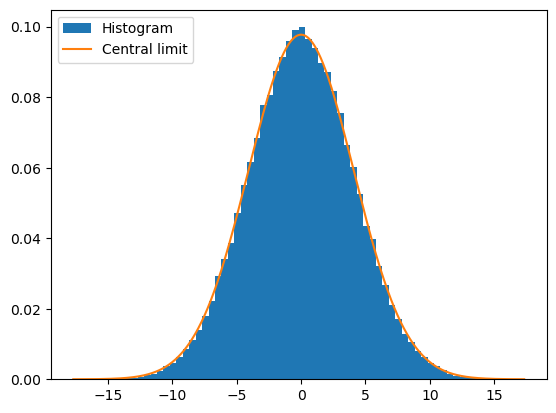

In [15]:
plt.hist(end_to_end, bins=70, density=True, label='Histogram');

central_limit = scipy.stats.norm(loc=0, scale=std_1 * n_mers**0.5)
x = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.plot(x, central_limit.pdf(x), label='Central limit')

plt.legend(loc='upper left')

For a sufficiently long chain ($N \rightarrow \infty$), i.e. the case described by the central limit theorem, you can use the known probability density (PDF) of the [normal distribtion](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) to find the force law exactly.

**Exercise 4**: Show that the entropic force exerted by a long ideal chain in the x-direction is described by:

\begin{equation}
F =  - \frac{3 k_B T}{\ell^2 N} x
\end{equation}

where $\ell$ is the link length of the polymer (which we took as 1 before), $N$ the number of links, $x$ the displacement in the x direction, $k_B$ Boltzmann's constant, and $T$ the temperature.